# Practica 4
## Captcha Destroyer hecho por: Python Haters
#### - Hugo Vivanco Fernandez
#### - Jaime Isar Muñoz
#### - Daniel Lafuente Bazo
#### - Óscar Fabián Pineda Germán

## Parte 0: Tratamiento de imagenes
Trabajamos con .png y tenemos que ser capaces de procesarlos, para esto usaremos cv2 (OpenCV)

## Parte 1: Reconocer un dígito o letra deformado

Para empezar el proyecto decidimos ir paso a paso. Primero identificaremos numeros y letras de forma individual. (logic CNN)

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 50, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 50, 200,   │        160 │ input_layer_14[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_42    │ (None, 25, 100,   │          0 │ conv2d_42[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 25, 100,   │      4,640 │ max_pooling2d_42… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_43    │ (None, 13, 50,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 13, 50,    │      9,248 │ max_pooling2d_43… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 50,    │        128 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_44    │ (None, 7, 25, 32) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 5600)      │          0 │ max_pooling2d_44… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_150 (Dense)   │ (None, 64)        │    358,464 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_152 (Dense)   │ (None, 64)        │    358,464 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_154 (Dense)   │ (None, 64)        │    358,464 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_156 (Dense)   │ (None, 64)        │    358,464 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_158 (Dense)   │ (None, 64)        │    358,464 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_151 (Dense)   │ (None, 36)        │      2,340 │ dense_150[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_153 (Dense)   │ (None, 36)        │      2,340 │ dense_152[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_155 (Dense)   │ (None, 36)        │      2,340 │ dense_154[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_157 (Dense)   │ (None, 36)        │      2,340 │ dense_156[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_159 (Dense)   │ (None, 36)        │      2,340 │ dense_158[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,818,196 (6.94 MB)

 Trainable params: 1,818,132 (6.94 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - dense_151_accuracy: 0.1222 - dense_151_loss: 3.2167 - dense_153_accuracy: 0.0909 - dense_153_loss: 3.3776 - dense_155_accuracy: 0.0739 - dense_155_loss: 3.4376 - dense_157_accuracy: 0.0408 - dense_157_loss: 3.6237 - dense_159_accuracy: 0.0575 - dense_159_loss: 3.5221 - loss: 17.1815 - val_dense_151_accuracy: 0.0000e+00 - val_dense_151_loss: 3.7372 - val_dense_153_accuracy: 0.0928 - val_dense_153_loss: 3.4506 - val_dense_155_accuracy: 0.0722 - val_dense_155_loss: 3.4499 - val_dense_157_accuracy: 0.1082 - val_dense_157_loss: 3.4705 - val_dense_159_accuracy: 0.1392 - val_dense_159_loss: 3.4815 - val_loss: 17.5907
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - dense_151_accuracy: 0.5142 - dense_151_loss: 1.9313 - dense_153_accuracy: 0.3505 - dense_153_loss: 2.3729 - dense_155_accuracy: 0.2230 - dense_155_loss: 2.5828 - dense_157_accuracy: 0.1752 - dense_157_loss: 2.7968 - dense_159_accuracy: 0.1351 - dense_159_loss: 2.8830 - loss: 

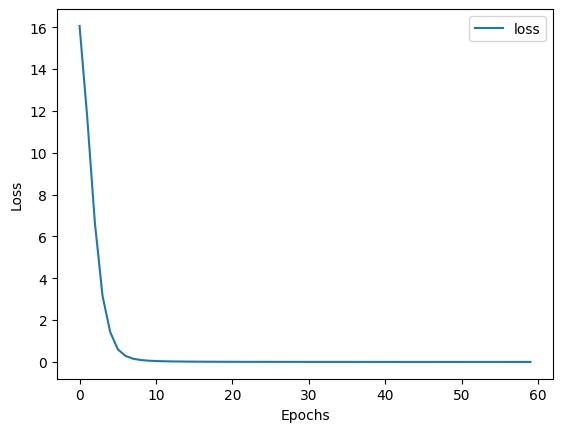

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - dense_151_accuracy: 0.8957 - dense_151_loss: 0.6195 - dense_153_accuracy: 0.9578 - dense_153_loss: 0.0222 - dense_155_accuracy: 0.9189 - dense_155_loss: 0.0370 - dense_157_accuracy: 0.8122 - dense_157_loss: 0.0304 - dense_159_accuracy: 0.9613 - dense_159_loss: 0.0323 - loss: 0.7049                    
Loss on training set= 5.272541522979736
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - dense_151_accuracy: 0.0000e+00 - dense_151_loss: 24.6864 - dense_153_accuracy: 0.7620 - dense_153_loss: 0.6094 - dense_155_accuracy: 0.7392 - dense_155_loss: 0.7385 - dense_157_accuracy: 0.5968 - dense_157_loss: 1.3609 - dense_159_accuracy: 0.7960 - dense_159_loss: 0.5350 - loss: 28.3553
Loss on testing set= 27.848249435424805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Predicted Captcha = 2b8c7


In [ ]:
from PIL import Image
import os
import tensorflow as tf
from keras import layers, models
from keras import Model
import matplotlib.pyplot as plt #for graphs
import numpy as np
import string
import cv2


symbols = string.ascii_lowercase + string.digits # All symbols captcha can contain
directorio_input = 'samples/'
directorio_output = 'samples_transform/'
CAPTCHA_LENGTH = 5
contador = 0

#total no of images in dataset
n = len( os.listdir(directorio_input) )
imgshape = (50,200,1) #50-height, 200-width, 1-no of channels

character= string.ascii_lowercase + string.digits # All symbols captcha can contain
nchar = len(character) #total number of char possible

#preprocesss image
def preprocess():
    X = np.zeros((n,50,200,1)) # 1070 (tamanio del dataset ) * 50 (altura de la imagen) * 200 (anchura de la imagen) (con todas las entradas a 0)
    y = np.zeros((5,n,nchar)) # 5 (letras de catchap) * 1070 (tamanio del dataset ) * 36 (posibles caracteres)  (con todas las entradas a 0)

    for i, pic in enumerate(os.listdir(directorio_input)):
    # i : indice en el que se encuentra la imagen en el directorio 
    # pic : contiene el nombre de la imagen en posicion i, que es equivalente a la solucion del catchap + .png
        
        img = cv2.imread(os.path.join(directorio_input, pic), cv2.IMREAD_GRAYSCALE) #guardamos la imagen en forma de matriz en una escala de blanco y negro
        pic_target = pic[:-4]# guardamos el objetimo (solucion del catchap), que es quivalente a el nombre - .png (.png = 4bits => -4)

        if len(pic_target) < 6: #solo captcha de 5 letras o menos
            img = img / 255.0 #escalar la imagen entre 0 y 1
            img = np.reshape(img, (50, 200, 1)) #redimensionas el array a 200 de ancho, 50 de alto , en channel 1 

            target=np.zeros((5,nchar)) #5 (letras de catchap) * 36 (posibles caracteres)  (con todas las entradas a 0)

            for j, k in enumerate(pic_target):
            # j : indice en el que se encuentra la imagen en el directorio
            # k : denotes the letter in captcha which is to be scanned
                index = symbols.find(k) # index stores the position of letter k of captcha in the character string
                target[j, index] = 1 # replaces 0 with 1 in the target array at the position of the letter in captcha

            X[i] = img # guardo las imagen en pos i 
            y[:,i] = target # guardo el target (solucion) en pos i

    return X, y

#create model
def createmodel():
    img = layers.Input(shape=imgshape) # Get image as an input of size 50,200,1
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img) #50*200
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 25*100
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 13*50
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3) #to improve the stability of model
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 7*25
    
    flat = layers.Flatten()(mp3) #convert the layer into 1-D

    outs = []
    for _ in range(5): #for 5 letters of captcha
        dens1 = layers.Dense(32, activation='relu')(flat)
        #drop = layers.Dropout(0.5)(dens1) #drops 0.5 fraction of nodes
        res = layers.Dense(nchar, activation='sigmoid')(dens1)

        outs.append(res) #result of layers
    
    # Compile model and return it
    model = Model(img, outs) #create model
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model


#Create model
model = createmodel()
model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'accuracy', 'accuracy', 'accuracy', 'accuracy']
)

X, y = preprocess()

#split the 1070 samples where 970 samples will be used for training purpose
split_index = ()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]
     

#Applying the model
hist = model.fit(
    X_train, 
    [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], 
    batch_size=32, 
    epochs=60, 
    validation_split=0.2
)

#graph of loss vs epochs
for label in ["loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#Loss on training set
#Finding Loss on training set
preds = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]])
print ("Loss on training set= " + str(preds[0]))


#Finding loss on test set
preds = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print ("Loss on testing set= " + str(preds[0]))

#to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    if img is not None: #image foud at file path
        img = img / 255.0 #Scale image
    else:
        print("Not detected")

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis])) #np.newaxis=1 
    #added this bcoz x_train 970*50*200*1
    #returns array of size 1*5*36 
    result = np.reshape(res, (5, 36)) #reshape the array
    probs = []
    for i in result:
        probs.append(np.argmax(i)) #adds the index of the char found in captcha

    capt = '' #string to store predicted captcha
    for k in probs:
        capt += character[k] #finds the char corresponding to the index
    return capt 

print("Predicted Captcha =", predict(directorio_output + '2b827.png'))